In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
!pip install tensorflow==2.18.0
!pip install numpy==1.26.4
!pip install pmdarima==2.0.4
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go

In [35]:
from google.colab import files
uploaded=files.upload()

Saving InsuranceUnemployedData.csv to InsuranceUnemployedData (2).csv


In [36]:
df=pd.read_csv(r"InsuranceUnemployedData.csv")
df.head()

,Year,Month,Region,County,Beneficiaries,Benefit Amounts (Dollars),Year-Month
0,2018,11,Capital,Albany,1600,1570000,2018-11
1,2018,11,Western New York,Allegany,400,300000,2018-11
2,2018,11,New York City,Bronx,11600,11530000,2018-11
3,2018,11,Southern Tier,Broome,1400,1150000,2018-11
4,2018,11,Western New York,Cattaraugus,900,710000,2018-11


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13760 entries, 0 to 13759
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Year                       13760 non-null  int64 
 1   Month                      13760 non-null  int64 
 2   Region                     13760 non-null  object
 3   County                     13760 non-null  object
 4   Beneficiaries              13760 non-null  int64 
 5   Benefit Amounts (Dollars)  13760 non-null  int64 
 6   Year-Month                 13760 non-null  object
dtypes: int64(4), object(3)
memory usage: 752.6+ KB


In [38]:
df.shape

(13760, 7)

In [39]:
df.isna().sum()

,0
Year,0
Month,0
Region,0
County,0
Beneficiaries,0
Benefit Amounts (Dollars),0
Year-Month,0


In [40]:
df.Region.value_counts()

,count
Region,
Finger Lakes,1935
Capital,1720
Southern Tier,1720
North Country,1505
Hudson Valley,1505
Mohawk Valley,1290
Western New York,1075
New York City,1075
Central New York,1075


In [41]:
df.duplicated().sum()

0

In [42]:
df.describe()

,Year,Month,Beneficiaries,Benefit Amounts (Dollars)
count,13760.000000,13760.000000,13760.000000,1.376000e+04
mean,2009.460465,6.474419,3858.335756,3.846968e+06
std,5.167803,3.439709,6557.550710,6.878640e+06
min,2001.000000,1.000000,0.000000,0.000000e+00
25%,2005.000000,3.000000,600.000000,5.700000e+05
50%,2009.000000,6.000000,1200.000000,1.110000e+06
75%,2014.000000,9.000000,2800.000000,2.720000e+06
max,2018.000000,12.000000,50700.000000,5.681000e+07


In [43]:
import plotly.express as px
fig=px.line(df,x='Year',y='Benefit Amounts (Dollars)')
fig.show()

In [44]:
fig=px.line(df,x='Year',y='Beneficiaries')
fig.show()

In [45]:
df1=df.query("County in ['Hamilton','Kings']")
fig=px.line(df1,x='Year',y='Beneficiaries', color='County', markers=True)
fig.update_traces(textposition="bottom right")
fig.show()

In [46]:
fig=px.bar(df,x='Region',y='Beneficiaries',color='Region',text_auto=True)
fig.show()

<Axes: xlabel='Region', ylabel='Beneficiaries'>

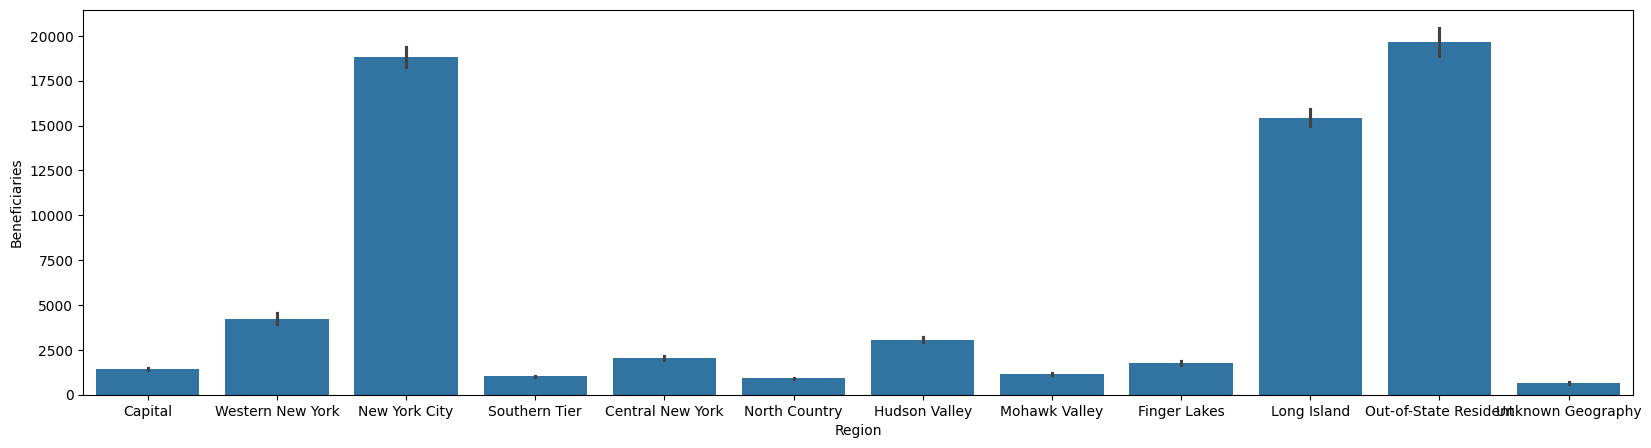

In [47]:
plt.figure(figsize=(20,5))
sns.barplot(x=df.Region,y=df.Beneficiaries)

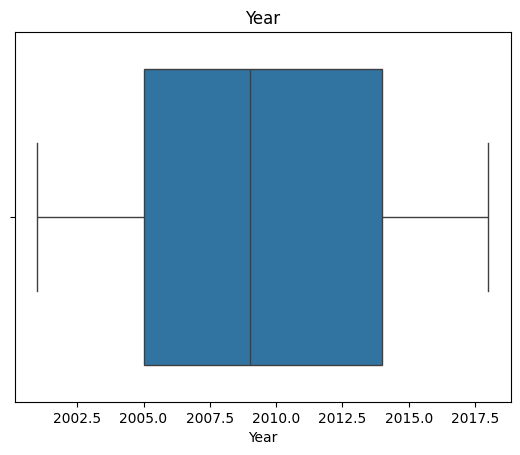

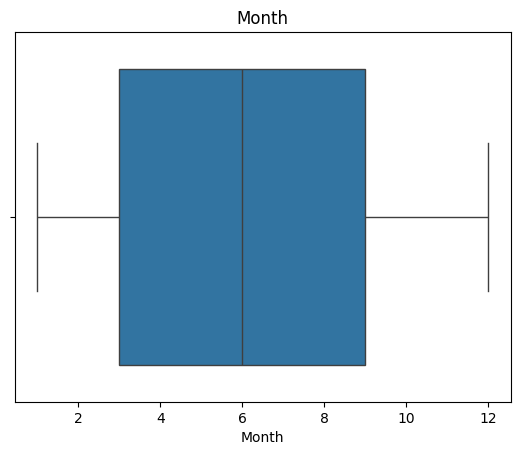

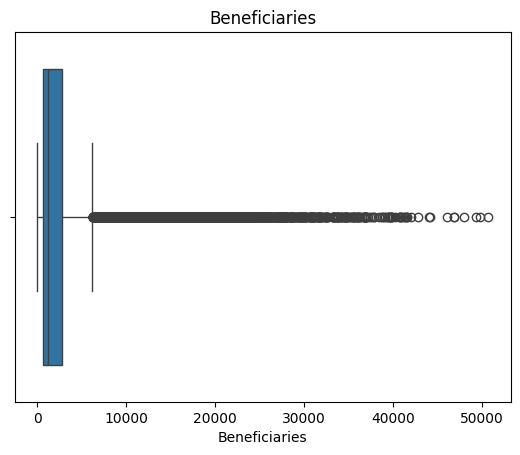

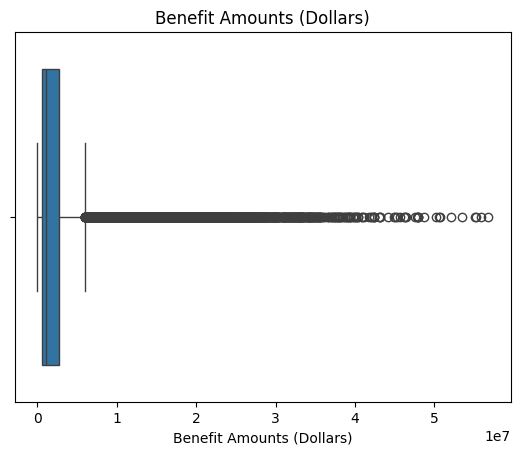

In [48]:
for i in df.columns:
	if (df[i].dtype)=='int64':
		boxplot=sns.boxplot(x=df[i])
		plt.title(i)
		plt.show()

In [49]:
df['ds']=pd.to_datetime(df['Year'].astype(str)+'-'+df['Month'].astype(str).str.zfill(2))
df_monthly=df.groupby('ds').agg({'Beneficiaries':'sum','Benefit Amounts (Dollars)':'sum'}).reset_index()
df_monthly.describe()

,ds,Beneficiaries,Benefit Amounts (Dollars)
count,215,215.000000,2.150000e+02
mean,2009-11-30 17:51:37.674418688,246933.488372,2.462060e+08
min,2001-01-01 00:00:00,124900.000000,1.340700e+08
25%,2005-06-16 00:00:00,194350.000000,1.921550e+08
50%,2009-12-01 00:00:00,236300.000000,2.309200e+08
75%,2014-05-16 12:00:00,288050.000000,2.865300e+08
max,2018-11-01 00:00:00,456700.000000,5.354200e+08
std,NaN,67465.360405,7.187324e+07


In [50]:
adf=adfuller(df_monthly['Beneficiaries'],autolag='AIC')
print("P-Value: ",adf)

P-Value:  (-1.4887605551942968, 0.5390638237887122, 15, 199, {'1%': -3.4636447617687436, '5%': -2.8761761179270766, '10%': -2.57457158581854}, 4370.400374111512)


In [51]:
train_size=int(len(df_monthly)*0.8)
train,test=df_monthly[:train_size],df_monthly[train_size:]

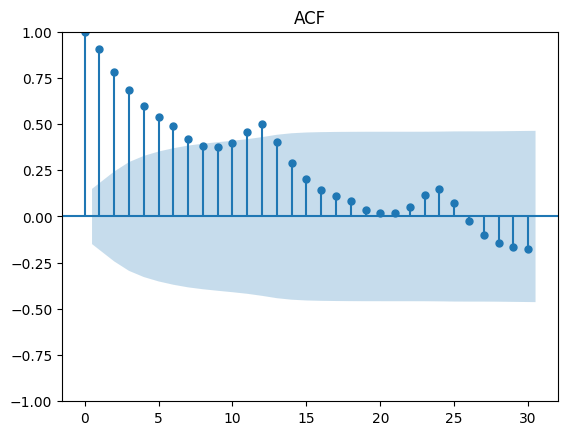

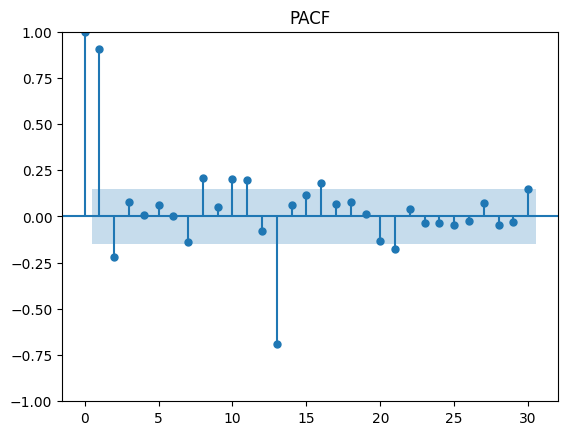

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train['Beneficiaries'],lags=30,title='ACF')
plot_pacf(train['Beneficiaries'],lags=30,title='PACF')
plt.show()

In [53]:
stepwise=auto_arima(train['Beneficiaries'],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3992.237, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4292.733, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3995.922, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4187.743, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4794.556, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3990.611, Time=0.44 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4153.004, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3988.854, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3991.030, Time=0.54 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3989.304, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4000.579, Time=0.88 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 4.404 seconds


In [54]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Beneficiaries'],order=(1,0,1))
model_arima=model.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Beneficiaries   No. Observations:                  172
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1990.165
Date:                Mon, 30 Jun 2025   AIC                           3988.330
Time:                        14:30:04   BIC                           4000.920
Sample:                             0   HQIC                          3993.438
                                - 172                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.645e+05   1.95e+04     13.537      0.000    2.26e+05    3.03e+05
ar.L1          0.8607      0.044     19.610      0.000       0.775       0.947
ma.L1          0.2675      0.091      2.926      0.003       0.088       0.447
sigma2      6.629e+08      0.538   1.23e+09      0.000    6.63e+08    6.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.97   Prob(JB):                         0.28
Heteroskedasticity (H):               1.23   Skew:                             0.29
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.88e+24. Standard errors may be unstable.
"""

In [55]:
predictions_arima=model_arima.forecast(steps=len(test))
mae_arima=mean_absolute_error(test['Beneficiaries'],predictions_arima)
mse_arima=mean_squared_error(test['Beneficiaries'],predictions_arima)
rmse_arima=np.sqrt(mse_arima)
r2_arima=r2_score(test['Beneficiaries'],predictions_arima)

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train['Beneficiaries'],order=(1,0,1),seasonal_order=(0,1,1,12))
model_sarima=model.fit()
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      Beneficiaries   No. Observations:                  172
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1797.712
Date:                            Mon, 30 Jun 2025   AIC                           3603.424
Time:                                    14:30:07   BIC                           3615.725
Sample:                                         0   HQIC                          3608.419
                                            - 172                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9461      0.016     58.464      0.000       0.914       0.978
ma.L1         -0.1997      0.060     -3.325      0.001      -0.317      -0.082
ma.S.L12      -0.7650      0.061    -12.535      0.000      -0.885      -0.645
sigma2      2.811e+08   7.34e-11   3.83e+18      0.000    2.81e+08    2.81e+08
===================================================================================
Ljung-Box (L1) (Q):                   4.80   Jarque-Bera (JB):               123.45
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.8e+34. Standard errors may be unstable.
"""

In [57]:
predictions_sarima=model_sarima.forecast(steps=len(test))
mae_sarima=mean_absolute_error(test['Beneficiaries'],predictions_sarima)
mse_sarima=mean_squared_error(test['Beneficiaries'],predictions_sarima)
rmse_sarima=np.sqrt(mse_sarima)
r2_sarima=r2_score(test['Beneficiaries'],predictions_sarima)

In [58]:
from statsmodels.tsa.ar_model import AutoReg
model=AutoReg(train['Beneficiaries'],lags=12)
model_ar=model.fit()
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:          Beneficiaries   No. Observations:                  172
Model:                    AutoReg(12)   Log Likelihood               -1838.665
Method:               Conditional MLE   S.D. of innovations          23687.916
Date:                Mon, 30 Jun 2025   AIC                           3705.331
Time:                        14:30:07   BIC                           3748.383
Sample:                            12   HQIC                          3722.813
                                  172                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.217e+04   9983.998      1.219      0.223   -7401.418    3.17e+04
Beneficiaries.L1      1.1064      0.078     14.146      0.000       0.953       1.260
Beneficiaries.L2     -0.3057      0.115     -2.668      0.008      -0.530      -0.081
Beneficiaries.L3      0.0702      0.117      0.600      0.549      -0.159       0.299
Beneficiaries.L4      0.0087      0.117      0.074      0.941      -0.220       0.238
Beneficiaries.L5     -0.0826      0.116     -0.712      0.477      -0.310       0.145
Beneficiaries.L6      0.2805      0.112      2.496      0.013       0.060       0.501
Beneficiaries.L7     -0.3667      0.112     -3.266      0.001      -0.587      -0.147
Beneficiaries.L8      0.1711      0.116      1.474      0.140      -0.056       0.399
Beneficiaries.L9     -0.0898      0.117     -0.769      0.442      -0.319       0.139
Beneficiaries.L10    -0.0585      0.117     -0.500      0.617      -0.288       0.171
Beneficiaries.L11     0.3145      0.115      2.740      0.006       0.089       0.539
Beneficiaries.L12    -0.0960      0.079     -1.222      0.222      -0.250       0.058
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1843           -0.2354j            1.2075           -0.4688
AR.2            -1.1843           +0.2354j            1.2075            0.4688
AR.3            -0.6381           -0.8916j            1.0964           -0.3489
AR.4            -0.6381           +0.8916j            1.0964            0.3489
AR.5            -0.0740           -1.1794j            1.1817           -0.2600
AR.6            -0.0740           +1.1794j            1.1817            0.2600
AR.7             0.5397           -0.9421j            1.0857           -0.1672
AR.8             0.5397           +0.9421j            1.0857            0.1672
AR.9             1.0255           -0.0000j            1.0255           -0.0000
AR.10            0.9828           -0.4564j            1.0836           -0.0692
AR.11            0.9828           +0.4564j            1.0836            0.0692
AR.12            2.9968           -0.0000j            2.9968           -0.0000
------------------------------------------------------------------------------
"""

In [59]:
predictions_ar=model_ar.forecast(steps=len(test))
mae_ar=mean_absolute_error(test['Beneficiaries'],predictions_ar)
mse_ar=mean_squared_error(test['Beneficiaries'],predictions_ar)
rmse_ar=np.sqrt(mse_ar)
r2_ar=r2_score(test['Beneficiaries'],predictions_ar)

In [60]:
from statsmodels.tsa.api import VAR
model=VAR(train[['Beneficiaries','Benefit Amounts (Dollars)']])
model_var=model.fit(maxlags=12,ic='aic')
model_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Jun, 2025
Time:                     14:30:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    53.3782
Nobs:                     160.000    HQIC:                   52.8074
Log likelihood:          -4597.43    FPE:                5.84421e+22
AIC:                      52.4172    Det(Omega_mle):     4.37142e+22
--------------------------------------------------------------------
Results for equation Beneficiaries
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                             19336.189836     14422.309149            1.341           0.180
L1.Beneficiaries                      0.572936         0.224670            2.550     

In [61]:
predictions_var=model_var.forecast(train[['Beneficiaries','Benefit Amounts (Dollars)']].values,steps=len(test))
pred_var_beneficiaries=predictions_var[:,0]
mae_var=mean_absolute_error(test['Beneficiaries'],pred_var_beneficiaries)
mse_var=mean_squared_error(test['Beneficiaries'],pred_var_beneficiaries)
rmse_var=np.sqrt(mse_var)
r2_var=r2_score(test['Beneficiaries'],pred_var_beneficiaries)

In [62]:
from prophet import Prophet
prophet_df=df_monthly[['ds','Beneficiaries']].copy()
prophet_df.columns=['ds','y']
prophet_df['y']=np.log(prophet_df['y'])
train=prophet_df.iloc[:-12]
test=prophet_df.iloc[-12:]
model_prophet=Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False,seasonality_mode='multiplicative',changepoint_prior_scale=1)
model_prophet.fit(train)
future=model_prophet.make_future_dataframe(periods=len(test),freq='M')
forecast=model_prophet.predict(future)
forecast['yhat']=np.exp(forecast['yhat'])
forecast['yhat_lower']=np.exp(forecast['yhat_lower'])
forecast['yhat_upper']=np.exp(forecast['yhat_upper'])

DEBUG:cmdstanpy:input tempfile: /tmp/tmp54ch63lj/z90c3wsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp54ch63lj/codrrag1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67654', 'data', 'file=/tmp/tmp54ch63lj/z90c3wsi.json', 'init=/tmp/tmp54ch63lj/codrrag1.json', 'output', 'file=/tmp/tmp54ch63lj/prophet_modelv0u3zrx_/prophet_model-20250630143007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:30:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:30:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [63]:
actual_values=np.exp(test['y'].values)
predicted_values=forecast[-len(test):]['yhat'].values
mae_prophet=mean_absolute_error(actual_values,predicted_values)
mse_prophet=mean_squared_error(actual_values,predicted_values)
rmse_prophet=np.sqrt(mse_prophet)
r2_prophet=r2_score(actual_values,predicted_values)

In [64]:
results_df=pd.DataFrame({
    'Model':['ARIMA','SARIMA','AutoReg','VAR','Prophet'],
    'MAE':[mae_arima,mae_sarima,mae_ar,mae_var,mae_prophet],
    'MSE':[mse_arima,mse_sarima,mse_ar,mse_var,mse_prophet],
    'RMSE':[rmse_arima,rmse_sarima,rmse_ar,rmse_var,rmse_prophet],
    'R2 Score':[r2_arima,r2_sarima,r2_ar,r2_var,r2_prophet]
})
print(results_df)

     Model           MAE           MSE          RMSE   R2 Score
0    ARIMA  81559.241268  7.528857e+09  86768.989032  -9.558157
1   SARIMA  45916.220746  2.485240e+09  49852.179807  -2.485197
2  AutoReg  58494.900977  4.242641e+09  65135.555370  -4.949703
3      VAR  86988.571653  8.364705e+09  91458.760445 -10.730315
4  Prophet   7477.543494  1.005451e+08  10027.218970   0.885509


From this, we can say that Prophet gives us the best results. now, let's print it's accuracy and plot it's forecast
Accuracy:  95.47774811359646


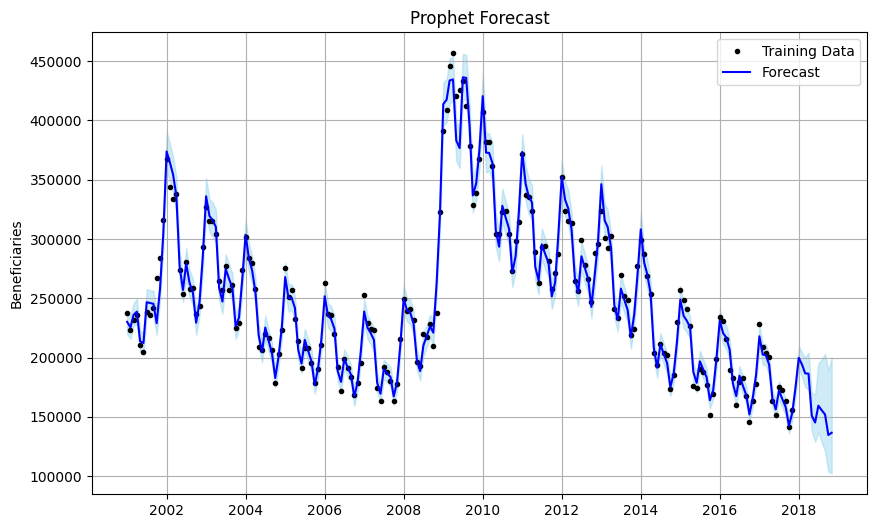

In [65]:
print("From this, we can say that Prophet gives us the best results. now, let's print it's accuracy and plot it's forecast")
accuracy=max(0,1-mae_prophet/np.mean(actual_values))*100
print("Accuracy: ",accuracy)
fig,ax=plt.subplots(figsize=(10, 6))
ax.plot(train['ds'],np.exp(train['y']),'k.',label='Training Data')
ax.plot(forecast['ds'],forecast['yhat'],color='blue',label='Forecast')
ax.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'],color='skyblue',alpha=0.4)
ax.set_title('Prophet Forecast')
ax.set_ylabel('Beneficiaries')
ax.legend()
plt.grid(True)
plt.show()

In [66]:
import pickle
with open("model.pkl","wb") as f:
    pickle.dump(model_prophet,f)
from google.colab import files
files.download("model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>